In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad
from functools import partial
import jax.random as random
key = random.PRNGKey(2022)
from jax.flatten_util import ravel_pytree
import jax.example_libraries.optimizers as optimizers

import matplotlib.pyplot as plt

from fem import plotmesh

# from jax.scipy.optimize import minimize
from scipy.optimize import minimize

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



In [2]:
def goh_PK1(u_grad, params, dim):
    C10, k1, k2 = params
    kappa = 0.1
    theta = 0.0
    #Kinematics
    F_2D = u_grad + jnp.eye(dim)
    C_2D = F_2D.T @ F_2D
    Cinv_2D = jnp.linalg.inv(C_2D)
    detC_2D = jnp.linalg.det(C_2D)
    C33 = 1/detC_2D
    C = jnp.array([  [C_2D[0,0], C_2D[0,1], 0],\
                    [C_2D[1,0], C_2D[1,1], 0],\
                    [0,         0,       C33]])
    C2 = C @ C
    Cinv = jnp.linalg.inv(C)
    I1 = C[0,0] + C[1,1] + C[2,2]
    trC2 = C2[0,0] + C2[1,1] + C2[2,2]
    I2 = 0.5*(I1**2 - trC2)
    v0 = jnp.array([ jnp.cos(theta), jnp.sin(theta), 0])
    V0 = jnp.outer(v0, v0)
    Iv = jnp.einsum('ij,ij',C,V0)


    # Energy/Stress
    E = kappa*(I1-3.0) + (1-3*kappa)*(Iv-1.0)
    E = jnp.maximum(E, 0.0)

    Psi1 = C10 + k1*kappa*E*jnp.exp(k2*E**2)
    Psiv = k1*(1-3*kappa)*E*jnp.exp(k2*E**2)
    Psi2 = 0.0

    p = -C[2,2]*(2*Psi1 + 2*Psi2*(I1 - C[2,2]) + 2*Psiv*V0[2,2])
    S = p*Cinv + 2*Psi1*jnp.eye(3) + 2*Psi2*(I1*jnp.eye(3)-C) + 2*Psiv*V0
    S_2D = S[:2,:2]
    P_2D = F_2D @ S_2D
    return P_2D
goh_PK1_vmap = vmap(goh_PK1, in_axes=(0,0,None))
def goh_sigma(u_grad, params, dim):
    F_2D = u_grad + jnp.eye(dim)
    P_2D = goh_PK1(u_grad, params, dim)
    return P_2D @ F_2D.T
goh_sigma_vmap = vmap(goh_sigma, in_axes=(0,0,None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: goh_PK1(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [147]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist_nh = []
node_x_hist_nh = []
P_hist_nh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)


    # GOH Material parameters
    r = np.sqrt((elem_X[:,0]-0.5)**2 + (elem_X[:,1]-0.5)**2)
    r = r/np.max(r)
    r_transition = 0.35
    s = 100 #controls (inversely) the smoothness of the transition. 
    sigmoid = 1/(1+np.exp(-s*(r-r_transition)))
    C10 = 0.5 + 0.2*sigmoid
    k1  = 0.1 + 0.02*sigmoid
    k2  = 0.2 + 0.04*sigmoid
    params = np.stack([C10,k1,k2]).T.reshape([-1,1,3])
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = goh_PK1_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_nh.append(F)
    node_x_hist_nh.append(node_x)
    P_hist_nh.append(P)
node_x_hist_nh = np.array(node_x_hist_nh)
F_hist_nh = np.array(F_hist_nh)
P_hist_nh = np.array(P_hist_nh)

[12-15 11:49:20][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-15 11:49:20][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-15 11:49:20][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-15 11:49:20][DEBUG] jax_fem: Done pre-computations, took 0.09434390068054199 [s]
[12-15 11:49:20][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-15 11:49:20][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-15 11:49:20][DEBUG] jax_fem: Start timing
[12-15 11:49:20][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-15 11:49:21][DEBUG] jax_fem: Function split_and_compute_cell took 1.0077 seconds
[12-15 11:49:21][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-15 11:49:21][DEBUG] jax_fem: Linear guess solve...
[12-15 11:49:21][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-15 11:49:21][DEBUG] jax_fem: PETSc

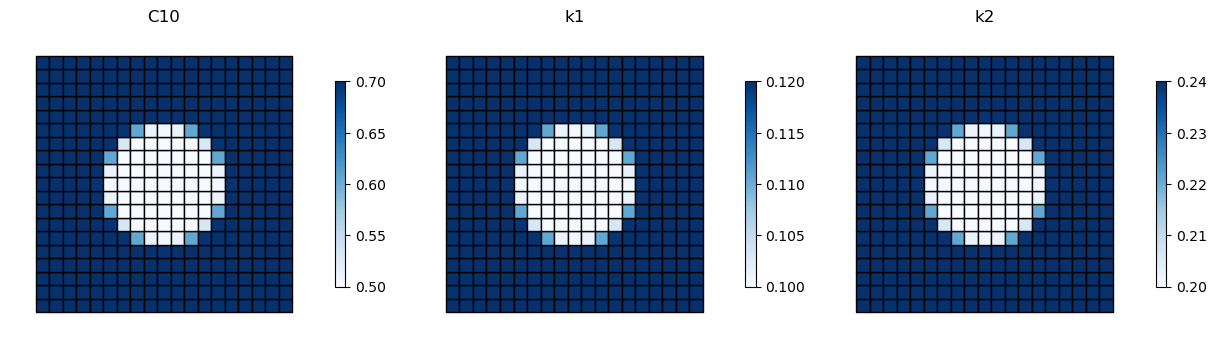

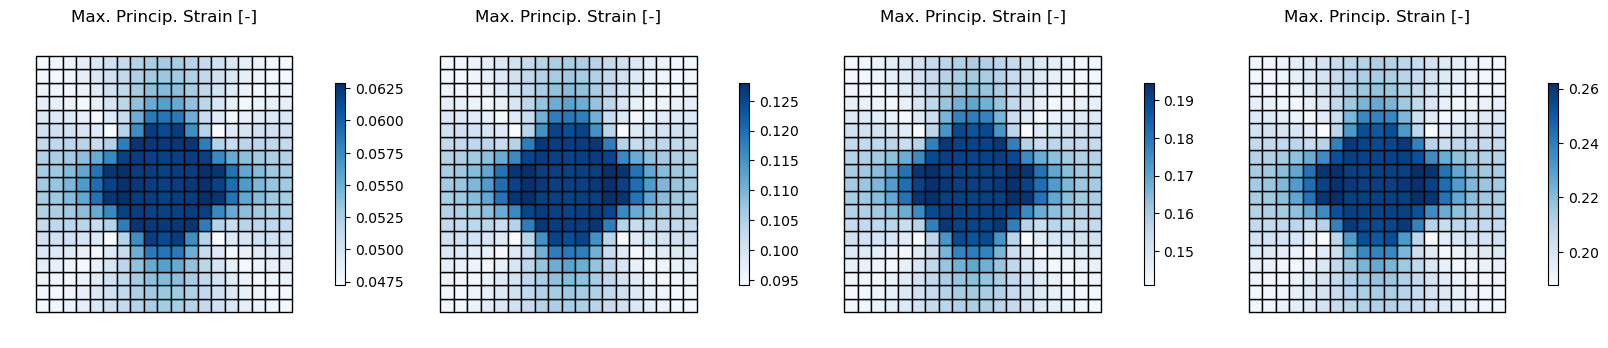

In [148]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
plotmesh(mesh.cells, mesh.points, C10, title='C10', ax=ax[0]); 
plotmesh(mesh.cells, mesh.points, k1, title='k1', ax=ax[1]); 
plotmesh(mesh.cells, mesh.points, k2, title='k2', ax=ax[2]); 


fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, P, ax in zip(t_hist, node_x_hist_nh, F_hist_nh, P_hist_nh, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)
    strains.append(np.array([t*np.ones_like(eps_xx), eps_xx, eps_yy]))
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 
strains = np.hstack(strains)

In [5]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(P_hist_nh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(P_hist_nh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(P_hist_nh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(P_hist_nh[:,bot_bd_elems,1,1], axis=1)
Fx = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Fy = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

rgt_bd_nodes = np.where(np.isclose(mesh.points[:,0], 1.0))
top_bd_nodes = np.where(np.isclose(mesh.points[:,1], 1.0))
lft_bd_nodes = np.where(np.isclose(mesh.points[:,0], 0.0))
bot_bd_nodes = np.where(np.isclose(mesh.points[:,1], 0.0))

In [29]:
def VF1(x,y,h,w,p):
    U_x = x**p/w**p
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF2(x,y,h,w,p):
    U_x = 0.0
    U_y = y**p/h**p
    return jnp.stack([U_x,U_y]).T

def VF3(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    U_y = jnp.sin(p*x*jnp.pi)*jnp.sin(p*y*jnp.pi)
    return jnp.stack([U_x,U_y]).T

def VF4(x,y,h,w,p):
    U_x = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    U_y = jnp.sin(p*x*jnp.pi/w)**2*jnp.sin(p*y*jnp.pi/h)**2
    return jnp.stack([U_x,U_y]).T

def VF5(x,y,h,w,p):
    U_x = 1.0-(x/w-1)**(2*p)
    U_y = 0.0
    return jnp.stack([U_x,U_y]).T

def VF6(x,y,h,w,p):
    U_x = 0.0
    U_y = 1.0-(y/h-1)**(2*p)
    return jnp.stack([U_x,U_y]).T

def VF_and_grad(VF, x, y, h, w, p):
    VF_dx = jax.jacfwd(VF, argnums=0)
    VF_dy = jax.jacfwd(VF, argnums=1)
    VF_grad = vmap(lambda x,y,h,w,p: jnp.stack([VF_dx(x,y,h,w,p), VF_dy(x,y,h,w,p)]).T, in_axes=(0,0,None,None,None))

    VF_vmap = vmap(VF, in_axes=(0,0,None,None,None))
    return VF_vmap(x,y,h,w,p), VF_grad(x,y,h,w,p)

def VF_and_grad_2(VF, x_elem, y_elem, x_node, y_node, h, w, p):
    VF_dx = jax.jacfwd(VF, argnums=0)
    VF_dy = jax.jacfwd(VF, argnums=1)
    VF_grad = vmap(lambda x,y,h,w,p: jnp.stack([VF_dx(x,y,h,w,p), VF_dy(x,y,h,w,p)]).T, in_axes=(0,0,None,None,None))

    VF_vmap = vmap(VF, in_axes=(0,0,None,None,None))
    return VF_vmap(x_node,y_node,h,w,p), VF_grad(x_elem,y_elem,h,w,p)

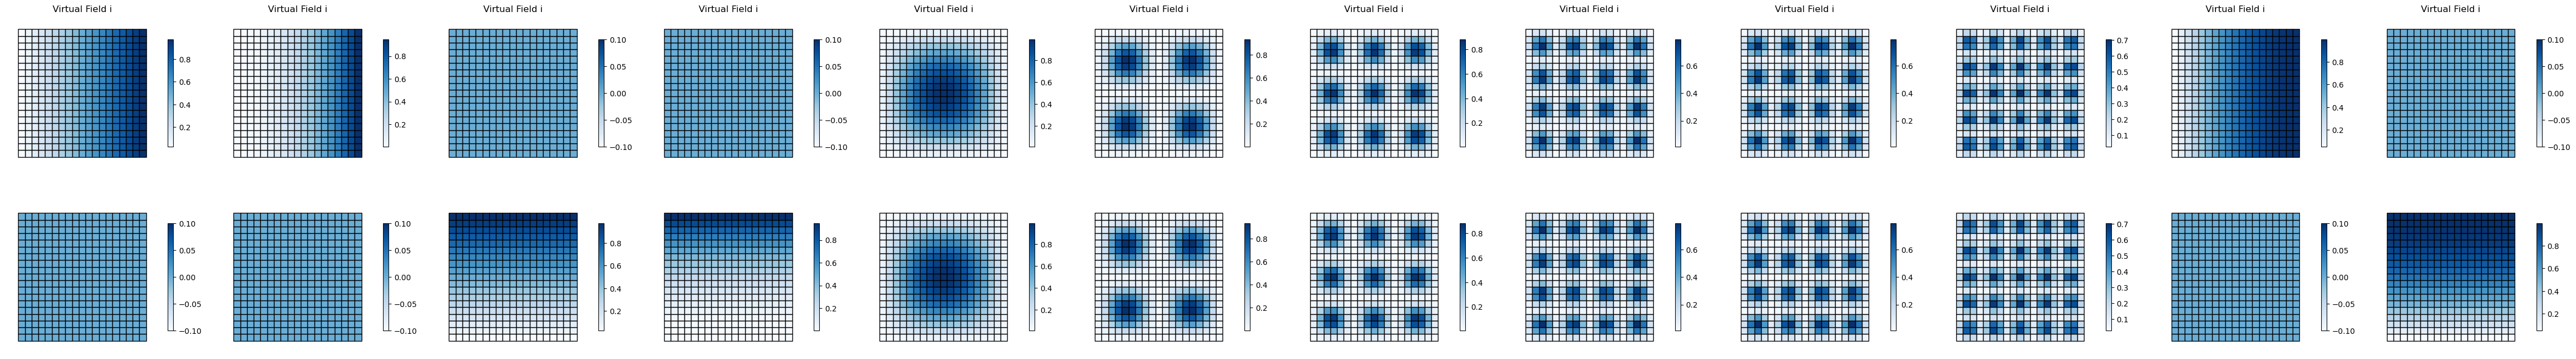

In [69]:
h = 1.0
w = 1.0
VF_list = [VF1, VF1, VF2, VF2, VF3, VF4, VF4, VF4, VF4, VF4, VF5, VF6]
p_list =  [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 3.0, 4.0, 4.0, 5.0, 1.0, 1.0]
# VF_list = [VF1, VF2, VF3, VF4]
# p_list =  [1.0, 1.0, 1.0, 2.0]
# VF_list = [VF3, VF3, VF4, VF4]
# p_list =  [1.0, 2.0, 1.0, 2.0]

x_elem, y_elem = elem_X.T
x_node, y_node = mesh.points.T
U, gradU = [], []
fig, axes = plt.subplots(2,len(VF_list),figsize=(len(VF_list)*5,8))
for ax, VF, p in zip(axes.T, VF_list, p_list):
    Ui, gradUi = VF_and_grad_2(VF, x_elem, y_elem, x_node, y_node, h, w, p)
    plotmesh(mesh.cells, mesh.points, Ui[mesh.cells,0].mean(axis=1), title='Virtual Field i', ax=ax[0]); 
    plotmesh(mesh.cells, mesh.points, Ui[mesh.cells,1].mean(axis=1), title=None, ax=ax[1]); 
    U.append(Ui)
    gradU.append(gradUi)
U, gradU = np.array(U), np.array(gradU)

In [156]:
# # Do this if you want to produce a working result
# params = np.stack([np.log(C10), np.log(k1), np.log(k2)]).T.reshape([-1,3])
# params.shape

(361, 3)

In [176]:
C10 = np.random.normal()
k1 = np.random.normal()
k2 = np.random.normal()
params = np.array([[C10, k1, k2]])
params = np.repeat(params, len(elem_X), axis=0)
params_ravel, unravel = ravel_pytree(params)

def eval_W_int(P, gradU):
    return jnp.einsum('ijk,ijk', P, gradU)
def eval_W_ext(U, Fx, Fy):
    W_rgt = jnp.sum(U[rgt_bd_nodes, 0]*Fx/len(rgt_bd_nodes))
    W_top = jnp.sum(U[top_bd_nodes, 1]*Fy/len(top_bd_nodes))
    W_lft = jnp.sum(U[lft_bd_nodes, 0]*Fx/len(lft_bd_nodes))
    W_bot = jnp.sum(U[bot_bd_nodes, 1]*Fy/len(bot_bd_nodes))
    return W_rgt + W_top

@jit
def obj_fn(params):
    loss = []
    for step in range(len(F_hist_nh)):
        F = F_hist_nh[step]
        u_grad = jnp.array(F - np.eye(2))
        P = goh_PK1_vmap(u_grad, unravel(jnp.exp(params)), 2)
        W_int = []
        W_ext = []
        for i_vf in range(len(U)):
            W_int.append(eval_W_int(P, gradU[i_vf]))
            W_ext.append(eval_W_ext(U[i_vf], Fx[step], Fy[step]))
        W_int = jnp.array(W_int)
        W_ext = jnp.array(W_ext)
        loss.append(jnp.sum((W_int-W_ext)**2))
    
    return jnp.sum(jnp.array(loss))

In [177]:
print("Obj func with initial: ", obj_fn(params_ravel))
sol = minimize(obj_fn, jac = grad(obj_fn), x0=params_ravel, method='CG', options={'gtol':0.1})
params = unravel(jnp.exp(sol.x))
print("Obj func with final: ", obj_fn(sol.x))
# FSC: Do multiple restarts

Obj func with initial:  1760867.3716398359
Obj func with final:  2.9407377298416666


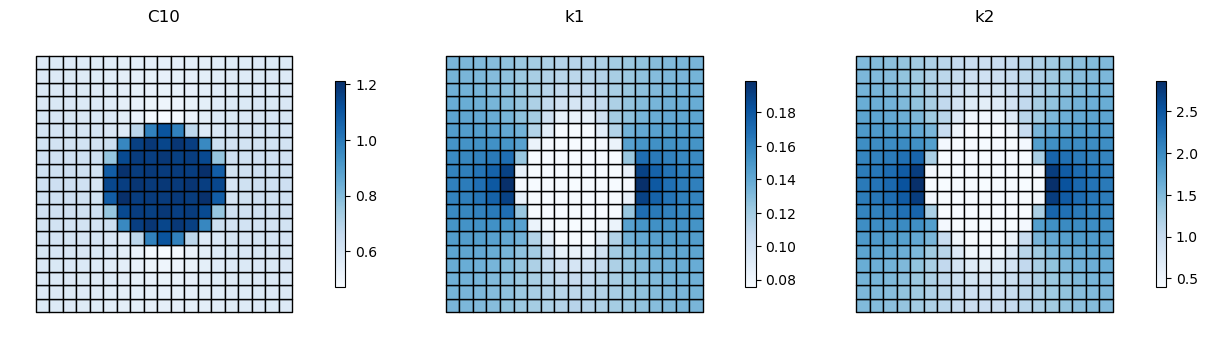

In [178]:
fig, ax = plt.subplots(1,3,figsize=(15,4)) 
plotmesh(mesh.cells, mesh.points, params[:,0], title='C10', ax=ax[0]); 
plotmesh(mesh.cells, mesh.points, params[:,1], title='k1', ax=ax[1]); 
plotmesh(mesh.cells, mesh.points, params[:,2], title='k2', ax=ax[2]); 

In [179]:
for step in range(len(F_hist_nh)):
    print("step ", step)
    F = F_hist_nh[step]
    u_grad = jnp.array(F - np.eye(2))
    P = goh_PK1_vmap(u_grad, unravel(jnp.exp(sol.x)), 2)
    for i_vf in range(len(U)):
        W_int = eval_W_int(P, gradU[i_vf])
        W_ext = eval_W_ext(U[i_vf], Fx[step], Fy[step])

        print(W_int, W_ext)

step  0
138.17909934485607 138.1430750261902
138.18001873345463 138.1430750261902
133.73961104419857 133.28892060209537
133.73921258606953 133.28892060209537
0.0007687252347885771 2.0057859491386146e-14
-1.9452970113063404e-05 7.734573024648087e-30
-9.854018216533885e-05 1.7402789305458187e-29
0.00010382313174980926 3.093829209859235e-29
0.00010382313174980926 3.093829209859235e-29
-6.740746630900629e-05 4.8341081404050537e-29
138.17817995625757 138.1430750261902
133.7400095023275 133.28892060209537
step  1
250.3755849189035 250.66763359281654
250.37726422303245 250.66763359281654
240.2662327892065 239.85162861674237
240.2655206737117 239.85162861674237
0.0014355181097111128 3.624762960034933e-14
4.254507636254107e-05 1.3977560179574394e-29
-7.52773466591179e-05 3.144951040404238e-29
0.00013174614693540289 5.591024071829759e-29
0.00013174614693540289 5.591024071829759e-29
-6.59317369653584e-05 8.735975112233998e-29
250.37390561477469 250.66763359281654
240.26694490470126 239.8516286167

In [180]:
params_vec = jnp.repeat(params.reshape([len(params),1,-1]), axis=1, repeats=4)

In [181]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
F_hist = []
node_x_hist = []
sigma_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)

    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    sigma = goh_sigma_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    sigma_hist.append(sigma)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
sigma_hist = np.array(sigma_hist)

[12-15 11:55:49][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[12-15 11:55:49][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[12-15 11:55:49][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[12-15 11:55:49][DEBUG] jax_fem: Done pre-computations, took 0.0471038818359375 [s]
[12-15 11:55:49][INFO] jax_fem: Solving a problem with 361 cells, 400x2 = 800 dofs.
[12-15 11:55:49][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[12-15 11:55:49][DEBUG] jax_fem: Start timing
[12-15 11:55:49][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[12-15 11:55:50][DEBUG] jax_fem: Function split_and_compute_cell took 1.0361 seconds
[12-15 11:55:50][DEBUG] jax_fem: Creating sparse matrix with scipy...
[12-15 11:55:50][DEBUG] jax_fem: Linear guess solve...
[12-15 11:55:50][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[12-15 11:55:50][DEBUG] jax_fem: PETSc 

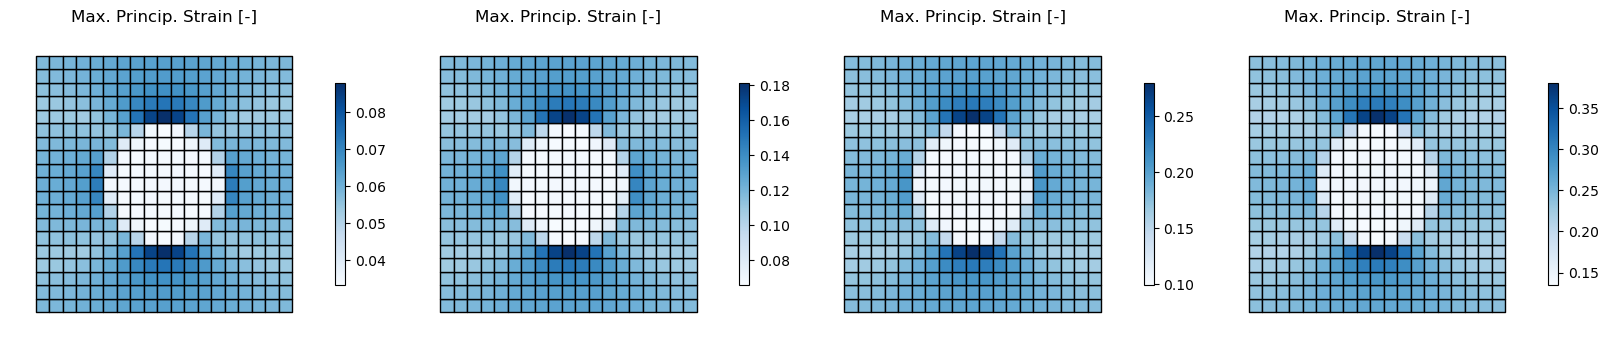

In [182]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, sigma, ax in zip(t_hist, node_x_hist, F_hist, sigma_hist, axes):
    eps_xx = F[:,0,0]-1.0
    eps_yy = F[:,1,1]-1.0

    mps = np.maximum(eps_xx, eps_yy)

    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 

In [186]:
steps = np.arange(len(F_hist_nh))
W_int_list = []
W_ext_list = []
for step in steps:
    print("step ", step)
    F = F_hist[step]
    u_grad = jnp.array(F - np.eye(2))
    P = goh_PK1_vmap(u_grad, unravel(jnp.exp(sol.x)), 2)
    W_int_step = []
    W_ext_step = []
    for i_vf in range(len(U)):
        W_int = eval_W_int(P, gradU[i_vf])
        W_ext = eval_W_ext(U[i_vf], Fx[step], Fy[step])

        print(W_int, W_ext)
        W_int_step.append(W_int)
        W_ext_step.append(W_ext)
    W_int_list.append(W_int_step)
    W_ext_list.append(W_ext_step)
W_int = np.array(W_int_list)
W_ext = np.array(W_ext_list)

step  0
128.82356595176478 138.1430750261902
128.82356787980143 138.1430750261902
121.88328473252315 133.28892060209537
121.88328340502187 133.28892060209537
1.1403517072732561e-05 2.0057859491386146e-14
-0.0003979527693246061 7.734573024648087e-30
0.0006889981048547551 1.7402789305458187e-29
-0.000865246741346853 3.093829209859235e-29
-0.000865246741346853 3.093829209859235e-29
0.0020416612636331272 4.8341081404050537e-29
128.8235640237282 138.1430750261902
121.88328606002433 133.28892060209537
step  1
234.57966729358364 250.66763359281654
234.5796715396195 250.66763359281654
218.80610220845844 239.85162861674237
218.8060980682755 239.85162861674237
2.5077537119986716e-05 3.624762960034933e-14
-0.0007248853779122732 1.3977560179574394e-29
0.0013778037245689777 3.144951040404238e-29
-0.0016624647422670428 5.591024071829759e-29
-0.0016624647422670428 5.591024071829759e-29
0.0036571278314624965 8.735975112233998e-29
234.5796630475477 250.66763359281654
218.80610634864132 239.851628616742

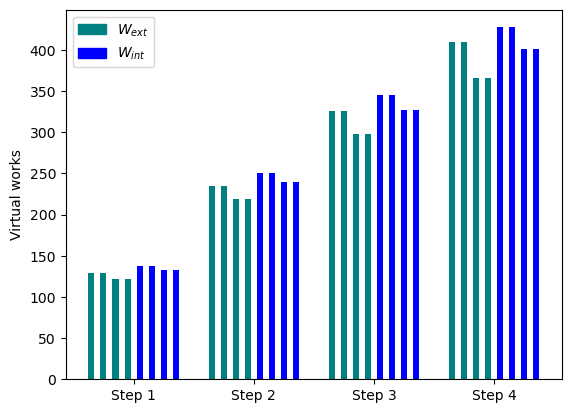

In [222]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
for step, W_int_step, W_ext_step in zip(steps, W_int, W_ext):
    width = 0.05
    for i in range(4):
        ax.bar(step+0.1*i,      W_int_step[i], color='teal', width = width)
        ax.bar(step+0.1*i+0.4,  W_ext_step[i], color='blue', width = width)
ax.set(ylabel = 'Virtual works')

teal_patch = mpatches.Patch(color='teal', label='$W_{ext}$')
blue_patch = mpatches.Patch(color='blue', label='$W_{int}$')
ax.legend(handles=[teal_patch, blue_patch])

ax.set_xticks(steps + 8*width - 0.05, ['Step 1', 'Step 2', 'Step 3', 'Step 4'])